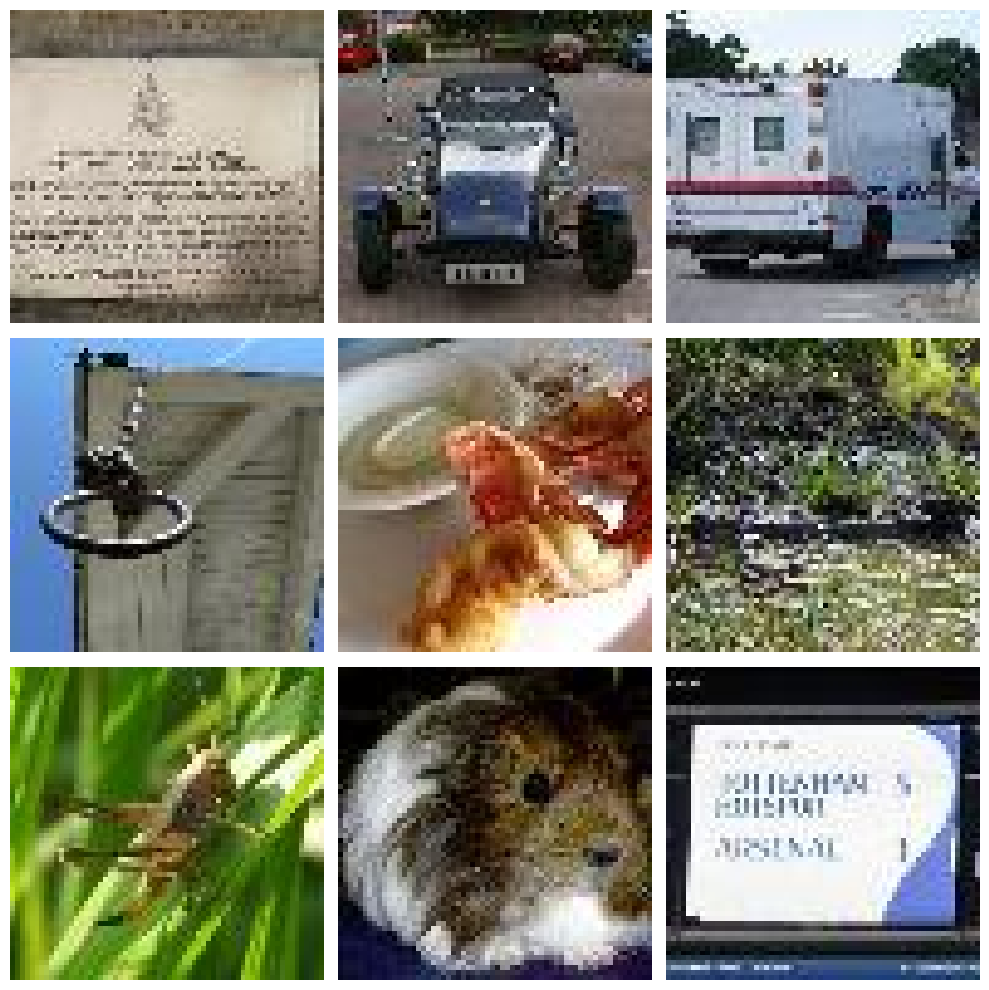

In [9]:
import matplotlib.pyplot as plt
import torch

# Obtener un batch del val_loader
dataiter = iter(val_loader)
images, _ = next(dataiter)
images = images[:9]  # Mostrar solo las primeras 9

# Llevar a CPU por si acaso
images = images.cpu()

# Función para mostrar una imagen
def imshow(img):
    img = img.permute(1, 2, 0).numpy()  # De CxHxW a HxWxC
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar
    plt.imshow(img)
    plt.axis('off')

# Mostrar 3x3 imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i])

plt.tight_layout()
plt.show()


🔧 Reorganizando conjunto de validación...
✅ Reorganización completada.
✅ Datos cargados:
  🔹 Entrenamiento: 100000 imágenes
  🔹 Validación: 10000 imágenes
📚 Época [1/15], Pérdida promedio: 4.5795
📚 Época [2/15], Pérdida promedio: 3.8534
📚 Época [3/15], Pérdida promedio: 3.5619
📚 Época [4/15], Pérdida promedio: 3.3846
📚 Época [5/15], Pérdida promedio: 3.2422
📚 Época [6/15], Pérdida promedio: 3.1133
📚 Época [7/15], Pérdida promedio: 2.9962
📚 Época [8/15], Pérdida promedio: 2.8747
📚 Época [9/15], Pérdida promedio: 2.7734
📚 Época [10/15], Pérdida promedio: 2.6618
📚 Época [11/15], Pérdida promedio: 2.5617
📚 Época [12/15], Pérdida promedio: 2.4630
📚 Época [13/15], Pérdida promedio: 2.3592
📚 Época [14/15], Pérdida promedio: 2.2767
📚 Época [15/15], Pérdida promedio: 2.1837


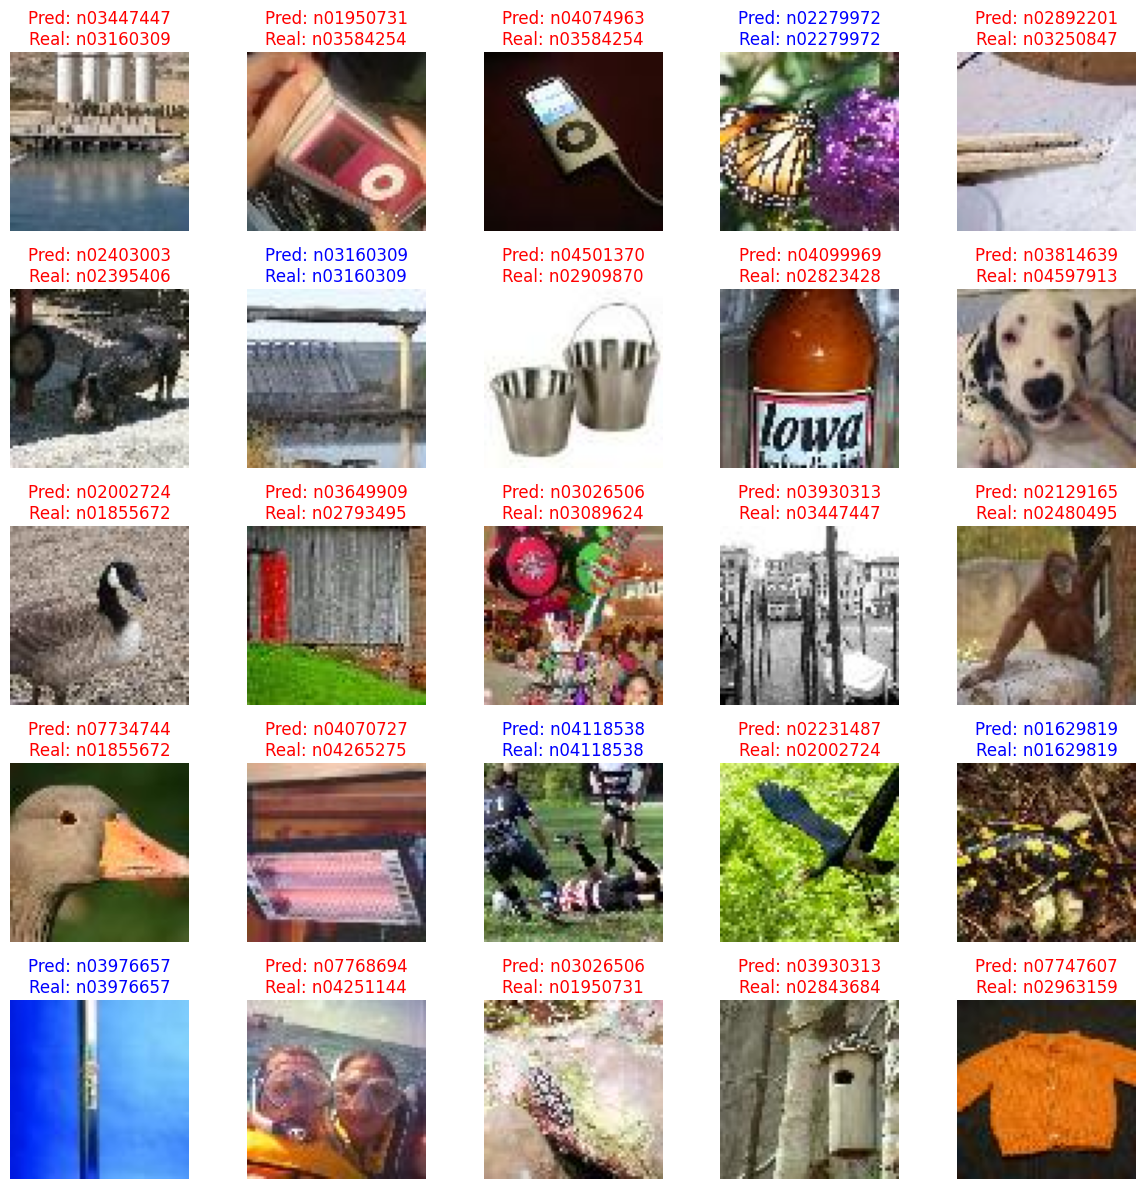

In [8]:
import os
import shutil
import zipfile
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------------------
# 1. Descargar y preparar Tiny ImageNet
# ------------------------------------------
base_dir = "/content/tiny-imagenet-200"
zip_path = "/content/tiny-imagenet-200.zip"

if not os.path.exists(base_dir):
    print("📥 Descargando Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    r = requests.get(url, stream=True)
    with open(zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    print("✅ Descarga completa. Descomprimiendo...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print("✅ Descompresión lista.")

# Reorganizar val/
val_dir = os.path.join(base_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_path = os.path.join(val_dir, 'val_annotations.txt')

print("🔧 Reorganizando conjunto de validación...")
with open(val_annotations_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        img_name = parts[0]
        label = parts[1]
        label_dir = os.path.join(val_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        img_path = os.path.join(val_images_dir, img_name)
        if os.path.exists(img_path):
            shutil.move(img_path, os.path.join(label_dir, img_name))

if os.path.exists(val_images_dir):
    os.rmdir(val_images_dir)
print("✅ Reorganización completada.")

# ------------------------------------------
# 2. Transformaciones y carga de datos
# ------------------------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)  # shuffle=True para aleatoriedad

print("✅ Datos cargados:")
print(f"  🔹 Entrenamiento: {len(train_dataset)} imágenes")
print(f"  🔹 Validación: {len(val_dataset)} imágenes")

# ------------------------------------------
# 3. Definir la arquitectura CNN
# ------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# ------------------------------------------
# 4. Entrenamiento
# ------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"📚 Época [{epoch+1}/{num_epochs}], Pérdida promedio: {avg_loss:.4f}")

# ------------------------------------------
# 5. Visualización de predicciones
# ------------------------------------------

# Leer nombres reales desde words.txt
words_path = os.path.join(base_dir, 'words.txt')
wnid_to_words = {}
with open(words_path, 'r') as f:
    for line in f:
        wnid, label = line.strip().split('\t')
        wnid_to_words[wnid] = label

# Poner el modelo en modo evaluación
model.eval()

# Obtener una batch aleatoria del val_loader
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Hacer predicciones
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Mover a CPU para visualización
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Mostrar predicciones simplificadas (solo wnid)
def imshow(img, title, correct):
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(title, color='blue' if correct else 'red')
    plt.axis('off')

fig = plt.figure(figsize=(12, 12))
for idx in range(25):
    ax = fig.add_subplot(5, 5, idx+1)

    pred_wnid = val_dataset.classes[predicted[idx]]
    true_wnid = val_dataset.classes[labels[idx]]

    correct = predicted[idx] == labels[idx]
    title = f"Pred: {pred_wnid}\nReal: {true_wnid}"

    imshow(images[idx], title, correct)

plt.tight_layout()
plt.show()
